# Personal Expense Time Series Analysis from 2013-2025

### Roadmap (some steps may not be used)

1. Data Cleaning & Preparation
  - Add additional features (e.g., `year`, `month`, `year_month`, etc.)
  - Aggregate to monthly total by category

2. Exploratory Time Series Analysis
  - Line plot of monthly total spending
  - Rolling averages
  - Seasonal decomposition
  - Autocorrelation plots (ACF/PACF)
  - High/low outliers

3. ARIMA & Forecasting
  - Check for Stationarity (ADF test)
  - Fit ARIMA/SARIMA
  - Evaluate residuals, AIC/BIC
  - Forecast future spend
  - Plot actual vs forecast

4. Machine Learning Forecasting (Gradient Boosting)
  - Lag values
  - Rolling stats
  - Date features
  - Category spend breakdowns
  - Target variable: next month spending
  - Time-based train/test split
  - Fit & evaluate
  - Metrics: RMSE, MAE

5. Insights & Interpretation
  - Compare models
  - Further discussion and clarifications
  - How can this be applied to other things?



In [1]:
from google.colab import files

import numpy as np
import pandas as pd
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
# Upload files
uploaded = files.upload()

Saving 2014-2025_expenses.csv to 2014-2025_expenses (1).csv


In [3]:
df = pd.read_csv('2014-2025_expenses.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5482 entries, 0 to 5481
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          5482 non-null   object
 1   name          5482 non-null   object
 2   price_cad     5482 non-null   object
 3   price_usd     1208 non-null   object
 4   old_category  5482 non-null   object
 5   new_category  5482 non-null   object
 6   essential     5482 non-null   int64 
 7   era           5482 non-null   object
dtypes: int64(1), object(7)
memory usage: 342.8+ KB


In [4]:
# Convert date to datetime and extract meaningful data
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5
df['year_month'] = df['date'].dt.to_period('M')
df['quarter'] = df['date'].dt.quarter

# Convert price (CAD) to float (will not be using USD)
df['price_cad'] = pd.to_numeric(
    df['price_cad'].str.replace('$','').str.replace(',',''))  # convert to float

In [5]:
# Check groups
df.groupby(['old_category', 'new_category'])['old_category'].value_counts()

old_category   new_category
Aesthetics     Clothing          31
               Hair              13
Badminton      Tournament       119
               Training         108
Books          Books            534
Business       Supplements      120
Car            Gas              286
               Insurance         23
               Parking           49
               Service           21
               Transit           22
Dining Out     Dining Out      1197
Education      Extra            106
               School            36
Entertainment  Games            166
               Music             38
               TV & Film         49
Event          Wedding           15
Financial      Banking           19
               Investment         6
               Taxes             22
Groceries      Groceries       1058
Medical        Medical           72
Merchandise    Gift              61
               Hobby             85
               Home             229
Rent           Rent             139
Travel         Accessory         28
               Food             368
               Stay              68
               Transport        228
Utilities      Electronics       68
               Household         48
               Software          50
Name: count, dtype: int64

# Data Visualizations

In [6]:
# Create Treemap Plots
# Essential Expenses
essential = df[df['essential'] == 1]

fig = px.treemap(
    essential.groupby(['old_category', 'new_category'])['price_cad'].sum().reset_index(),
    path=['old_category', 'new_category'],
    values='price_cad',
    title='Essential Spending Breakdown by Category and Subcategory',
)

fig.show()

In [7]:
# Non-Essential Expenses
nonessential = df[df['essential'] == 0]

fig = px.treemap(
    nonessential.groupby(['old_category', 'new_category'])['price_cad'].sum().reset_index(),
    path=['old_category', 'new_category'],
    values='price_cad',
    title='Non-Essential Spending Breakdown by Category and Subcategory',
)

fig.show()

In [8]:
# Set date as index
df.set_index('date', inplace=True)

# Resample: total monthly expenses (absolute value for expenses if negative)
monthly_expense = df['price_cad'].resample('ME').sum().abs()

# Reset index for plotting/modeling
monthly_expense = monthly_expense.reset_index()
monthly_expense.columns = ['date', 'monthly_total']

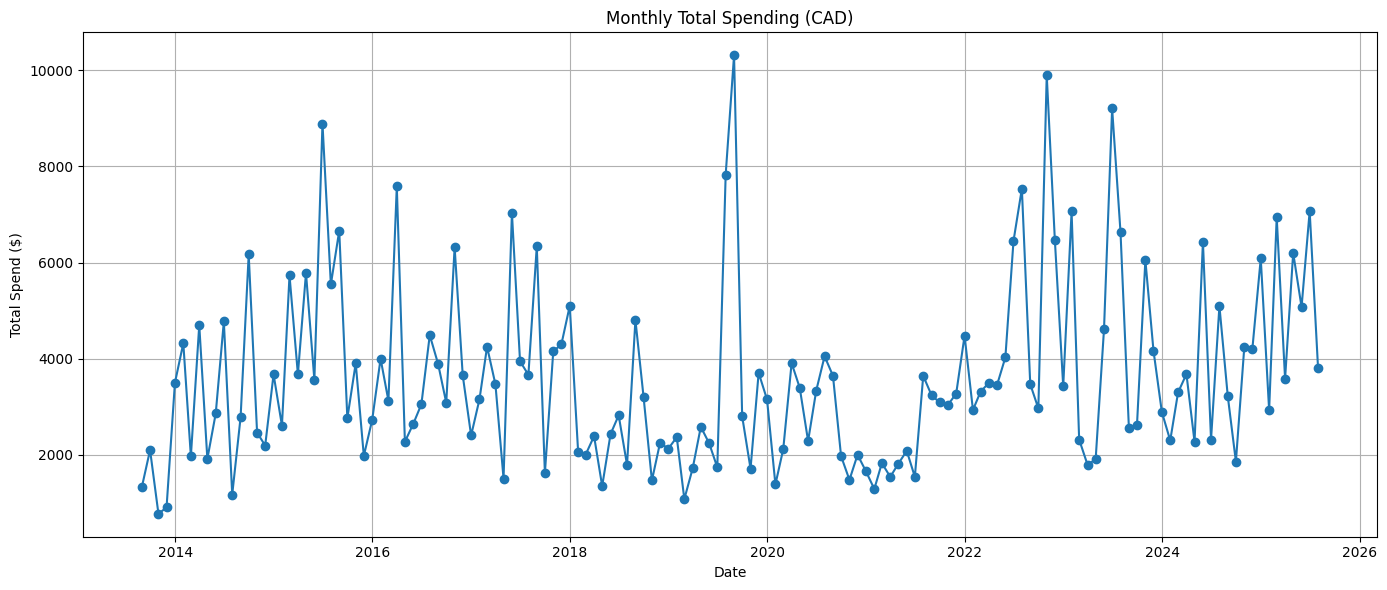

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_expense['date'], monthly_expense['monthly_total'], marker='o', linestyle='-')
plt.title('Monthly Total Spending (CAD)')
plt.xlabel('Date')
plt.ylabel('Total Spend ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

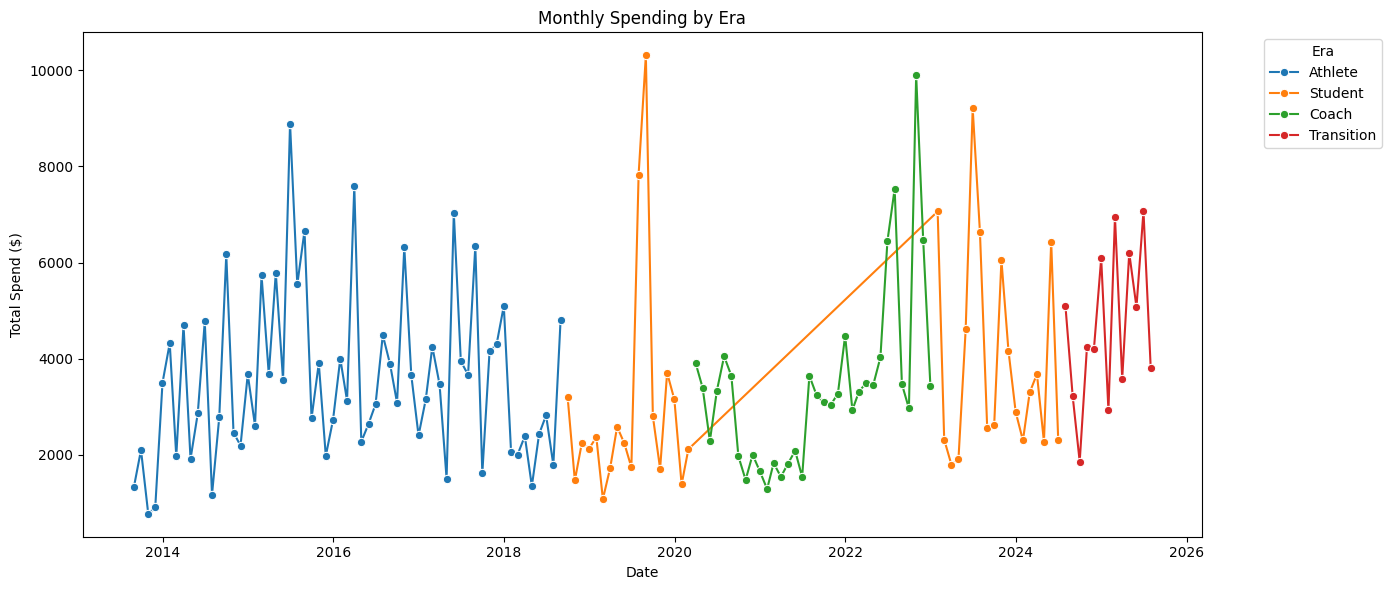

In [10]:
era_map = df.groupby('year_month')['era'].agg(lambda x: x.mode()[0])  # use mode in case of mixed eras

# Add same year_month column to monthly_expense
monthly_expense['year_month'] = monthly_expense['date'].dt.to_period('M')

# Merge
monthly_expense = monthly_expense.merge(era_map, on='year_month', how='left')

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_expense, x='date', y='monthly_total', hue='era', palette='tab10', marker='o')

plt.title('Monthly Spending by Era')
plt.xlabel('Date')
plt.ylabel('Total Spend ($)')
plt.legend(title='Era', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Time Series Analysis

#### Check for Stationarity with ADF Test

In [11]:
# ADF Test
ts = monthly_expense['monthly_total']

result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -9.40135245556225
p-value: 6.175291543142996e-16


#### Fit ARIMA model

In [12]:
# Fit ARIMA with d=0 since data is stationary
model = ARIMA(ts, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          monthly_total   No. Observations:                  144
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1286.762
Date:                Fri, 25 Jul 2025   AIC                           2581.524
Time:                        17:45:24   BIC                           2593.404
Sample:                             0   HQIC                          2586.351
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3602.3511    385.504      9.345      0.000    2846.777    4357.926
ar.L1          0.8217      0.123      6.678      0.000       0.581       1.063
ma.L1         -0.6592      0.151     -4.378      0.0

In [13]:
results = []

# Try combinations of (p,d,q) for d=0
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(ts, order=(p, 0, q))
            model_fit = model.fit()
            results.append({
                'order': (p, 0, q),
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'model': model_fit
            })
        except:
            continue  # skip if it fails to converge

In [14]:
# Sort by AIC
results_sorted = sorted(results, key=lambda x: x['aic'])

# Show top 5
for res in results_sorted[:5]:
    print(f"ARIMA{res['order']} | AIC: {res['aic']:.2f} | BIC: {res['bic']:.2f}")

ARIMA(1, 0, 1) | AIC: 2581.52 | BIC: 2593.40
ARIMA(1, 0, 0) | AIC: 2581.90 | BIC: 2590.81
ARIMA(2, 0, 2) | AIC: 2582.51 | BIC: 2600.33
ARIMA(0, 0, 1) | AIC: 2582.74 | BIC: 2591.65
ARIMA(1, 0, 2) | AIC: 2582.92 | BIC: 2597.77


In [15]:
# Assuming model_fit is best result i.e. ARIMA(1, 0, 1)
forecast = model_fit.forecast(steps=12)

# Build future date index
last_date = monthly_expense['date'].max()
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

# Combine into a forecast DataFrame
forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast': forecast
})

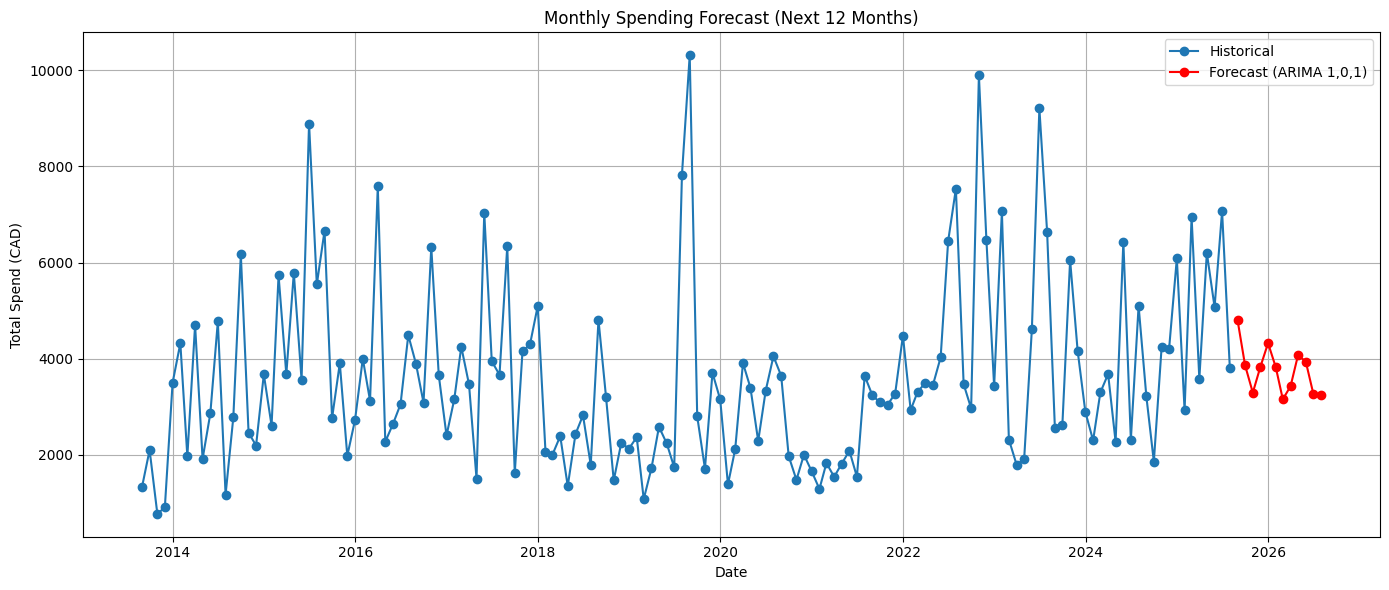

In [16]:
plt.figure(figsize=(14, 6))

# Historical monthly totals
plt.plot(monthly_expense['date'], monthly_expense['monthly_total'], label='Historical', marker='o')

# Forecasted future values
plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecast (ARIMA 1,0,1)', marker='o', color='red')

plt.title('Monthly Spending Forecast (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Total Spend (CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

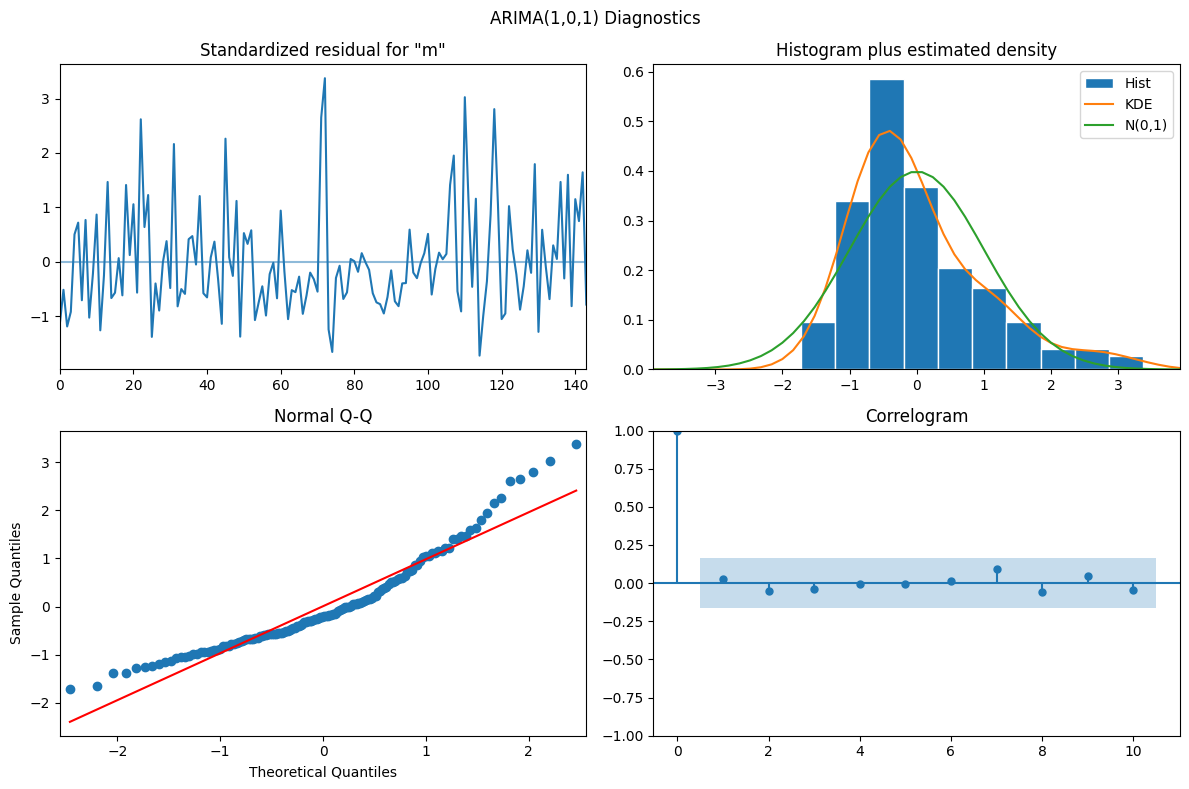

In [17]:
import statsmodels.api as sm

# Plot residual diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("ARIMA(1,0,1) Diagnostics")
plt.tight_layout()
plt.show()

#### Insights
1. Standardized Residuals
  - Mostly random noise, no major autocorrelation trend visible
2. Histogram
  - Mild non-normality, with slight left skew
3. Q-Q Plot
  - Most points hug line, with slight divergence in upper tail (i.e. positive outliers)
4. Correlogram
  - No significant autocorrelation

#### Try ARIMA on Most Recent Era

In [18]:
# Replace with your actual recent era name
recent_era = 'Transition'

df_recent = df[df['era'] == recent_era].copy()

# Monthly resample
recent_monthly = df_recent['price_cad'].resample('ME').sum().abs().reset_index()
recent_ts = recent_monthly['price_cad']

# ARIMA
recent_model = ARIMA(recent_ts, order=(1, 0, 1))
recent_fit = recent_model.fit()
print(recent_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              price_cad   No. Observations:                   13
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -112.431
Date:                Fri, 25 Jul 2025   AIC                            232.862
Time:                        17:45:28   BIC                            235.121
Sample:                             0   HQIC                           232.397
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4671.6459    425.130     10.989      0.000    3838.407    5504.885
ar.L1         -0.9459      0.478     -1.977      0.048      -1.883      -0.008
ma.L1          0.7824      0.875      0.895      0.3

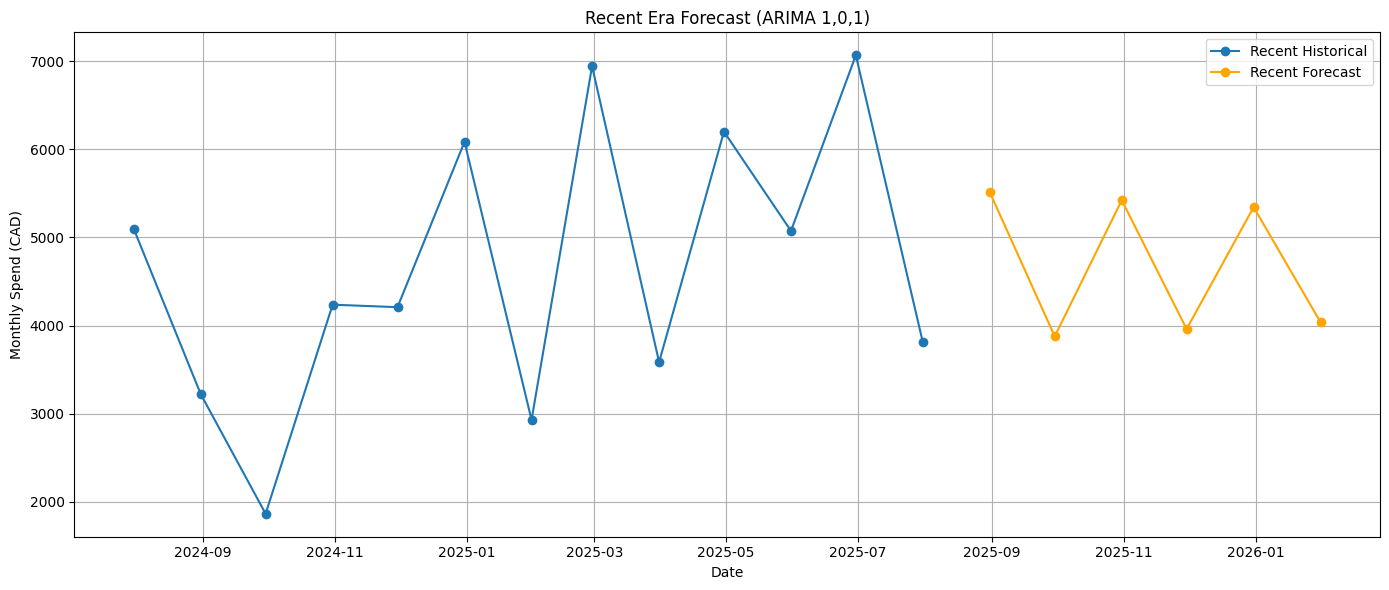

In [19]:
# Forecast with Most Recent Era
forecast_recent = recent_fit.forecast(steps=6)

# New forecast dates
last_date_recent = recent_monthly['date'].max()
forecast_index_recent = pd.date_range(start=last_date_recent + pd.DateOffset(months=1), periods=6, freq='M')

# Plot
plt.figure(figsize=(14,6))
plt.plot(recent_monthly['date'], recent_ts, label='Recent Historical', marker='o')
plt.plot(forecast_index_recent, forecast_recent, label='Recent Forecast', marker='o', color='orange')
plt.title('Recent Era Forecast (ARIMA 1,0,1)')
plt.xlabel('Date')
plt.ylabel('Monthly Spend (CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Compare Full and Recent Models

In [20]:
forecast_full = model_fit.forecast(steps=6)

# Use latest actual date
start_date = monthly_expense['date'].max() + pd.DateOffset(months=1)
forecast_index = pd.date_range(start=start_date, periods=6, freq='M')

forecast_df = pd.DataFrame({
    'date': forecast_index,
    'full_forecast': forecast_full.values,
    'recent_forecast': forecast_recent.values
})

In [21]:
# Compare Stats
print("Full-History Forecast")
print(f"  Min: ${forecast_df['full_forecast'].min():,.2f}")
print(f"  Max: ${forecast_df['full_forecast'].max():,.2f}")
print(f"  Mean: ${forecast_df['full_forecast'].mean():,.2f}")

print("\nRecent-Era Forecast")
print(f"  Min: ${forecast_df['recent_forecast'].min():,.2f}")
print(f"  Max: ${forecast_df['recent_forecast'].max():,.2f}")
print(f"  Mean: ${forecast_df['recent_forecast'].mean():,.2f}")

Full-History Forecast
  Min: $3,295.40
  Max: $4,802.41
  Mean: $3,989.68

Recent-Era Forecast
  Min: $3,876.60
  Max: $5,512.20
  Mean: $4,692.09


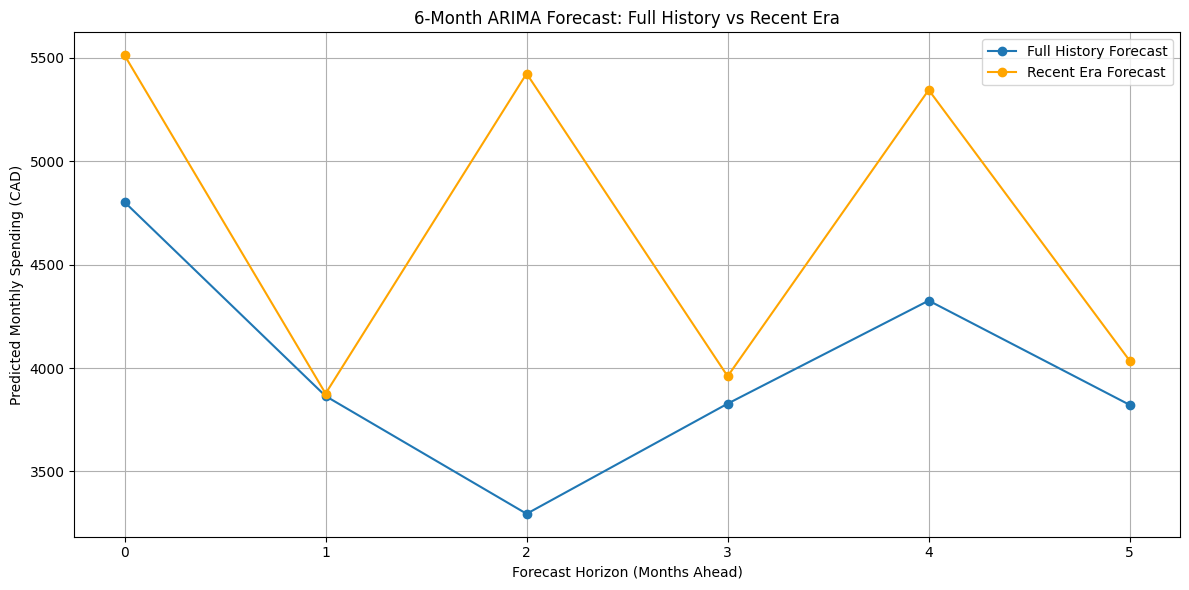

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['full_forecast'], label='Full History Forecast', marker='o')
plt.plot(forecast_df['recent_forecast'], label='Recent Era Forecast', marker='o', color='orange')
plt.title('6-Month ARIMA Forecast: Full History vs Recent Era')
plt.xlabel('Forecast Horizon (Months Ahead)')
plt.ylabel('Predicted Monthly Spending (CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Machine Learning Model (LGBM)

In [23]:
# Resample monthly totals
monthly = df['price_cad'].resample('ME').sum().abs().reset_index()
monthly.columns = ['date', 'monthly_total']

In [24]:
# Create Lag Features
for i in range(1, 4):
    monthly[f'lag_{i}'] = monthly['monthly_total'].shift(i)

In [25]:
# Rolling Mean & STD
monthly['rolling_mean_3'] = monthly['monthly_total'].rolling(window=3).mean().shift(1)
monthly['rolling_std_3'] = monthly['monthly_total'].rolling(window=3).std().shift(1)

In [26]:
# Calendar Features
monthly['month'] = monthly['date'].dt.month
monthly['quarter'] = monthly['date'].dt.quarter
monthly['year'] = monthly['date'].dt.year

In [27]:
# Drop NA rows from lags/rolling
monthly_model = monthly.dropna().copy()

features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3', 'month', 'quarter']
target = 'monthly_total'

In [28]:
# Use last 12 months as test
train = monthly_model.iloc[:-12]
test = monthly_model.iloc[-12:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [29]:
model = lgb.LGBMRegressor(**{'verbosity': -1})
model.fit(X_train, y_train)

LGBMRegressor(verbosity=-1)

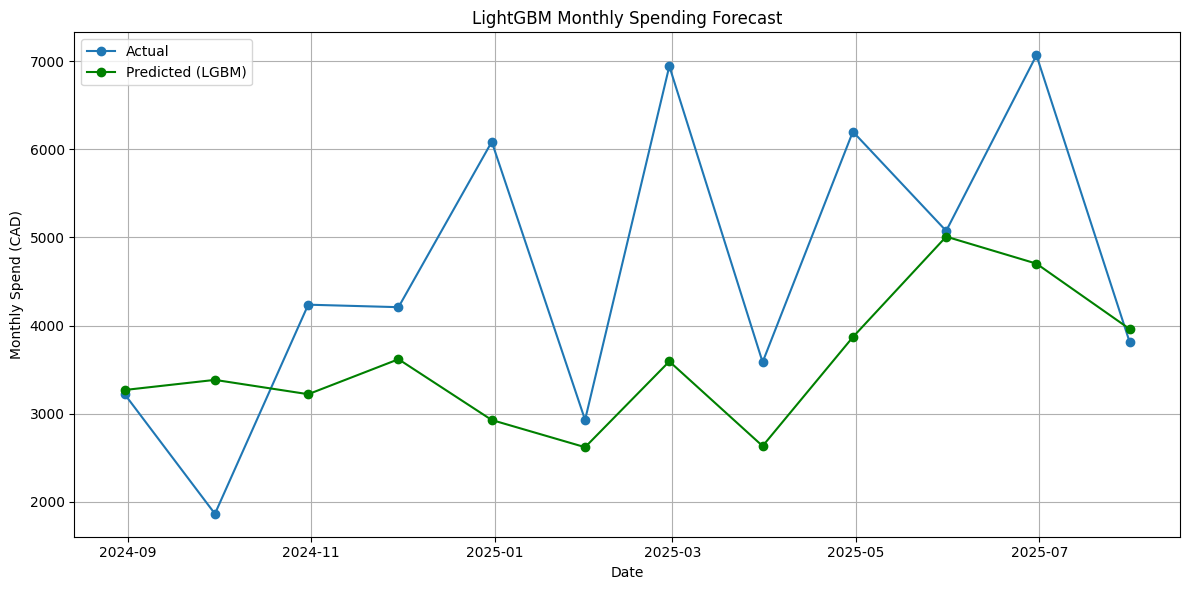

In [30]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test, label='Actual', marker='o')
plt.plot(test['date'], y_pred, label='Predicted (LGBM)', marker='o', color='green')
plt.title('LightGBM Monthly Spending Forecast')
plt.xlabel('Date')
plt.ylabel('Monthly Spend (CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: ${mae:,.2f}')
print(f'RMSE: ${rmse:,.2f}')

MAE: $1,322.28
RMSE: $1,755.92


# Forecast Next 6 Months With LGBM

In [32]:
# Create lag and rolling features
def create_features(df):
    df = df.copy()
    for i in range(1, 4):
        df[f'lag_{i}'] = df['monthly_total'].shift(i)
    df['rolling_mean_3'] = df['monthly_total'].rolling(3).mean().shift(1)
    df['rolling_std_3'] = df['monthly_total'].rolling(3).std().shift(1)
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    return df

monthly = create_features(monthly)
monthly_model = monthly.dropna().copy()

features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3', 'month', 'quarter']

In [33]:
# Train on Full Data
X_train = monthly_model[features]
y_train = monthly_model['monthly_total']

model = lgb.LGBMRegressor(**{'verbosity': -1})
model.fit(X_train, y_train)

LGBMRegressor(verbosity=-1)

In [34]:
# Rolling Forecast Loop for Next 6 Months
future_months = 6
last_date = monthly_model['date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_months, freq='M')

forecast_rows = []

current_data = monthly_model.copy()

for date in future_dates:
    last_rows = current_data.iloc[-3:].copy()

    lag_1 = last_rows.iloc[-1]['monthly_total']
    lag_2 = last_rows.iloc[-2]['monthly_total']
    lag_3 = last_rows.iloc[-3]['monthly_total']
    rolling_mean = last_rows['monthly_total'].mean()
    rolling_std = last_rows['monthly_total'].std()

    new_features = {
        'lag_1': lag_1,
        'lag_2': lag_2,
        'lag_3': lag_3,
        'rolling_mean_3': rolling_mean,
        'rolling_std_3': rolling_std,
        'month': date.month,
        'quarter': (date.month - 1) // 3 + 1
    }

    pred = model.predict(pd.DataFrame([new_features]))[0]

    forecast_rows.append({'date': date, 'predicted': pred})

    # Append prediction as new row for next loop
    new_row = pd.DataFrame([{
        'date': date,
        'monthly_total': pred,
        **new_features
    }])

    current_data = pd.concat([current_data, new_row], ignore_index=True)

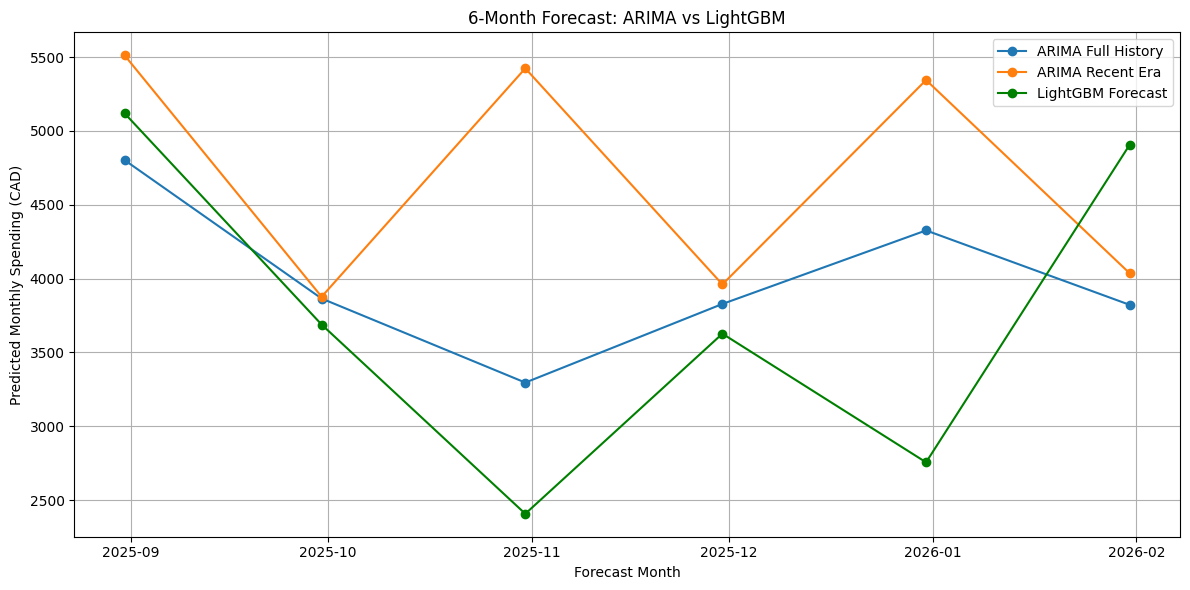

In [35]:
# Plot vs ARIMA
forecast_lgbm = pd.DataFrame(forecast_rows)
forecast_lgbm = forecast_lgbm.set_index('date')

# Use the same 6-month forecast_index:
forecast_lgbm = forecast_lgbm.loc[forecast_df['date']]

plt.figure(figsize=(12, 6))

plt.plot(forecast_df['date'], forecast_df['full_forecast'], label='ARIMA Full History', marker='o')
plt.plot(forecast_df['date'], forecast_df['recent_forecast'], label='ARIMA Recent Era', marker='o')
plt.plot(forecast_lgbm.index, forecast_lgbm['predicted'], label='LightGBM Forecast', marker='o', color='green')

plt.title('6-Month Forecast: ARIMA vs LightGBM')
plt.xlabel('Forecast Month')
plt.ylabel('Predicted Monthly Spending (CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretations

- ARIMA (Recent)
  - Highest baseline spending prediction
  - Strong seasonality
  - May better reflect current lifestyle
- ARIMA (Full)
  - Moderate baseline, more conservative
  - Averages out historical changes
- LGBM
  - Lowest baseline prediction with more variance
  - May capture feature interaction, but not long-term memory

#### Discussion

- The estimates are on the lower end, which is a good thing! Why? Because it encourages me to spend less in and effort to support the model predecitions. However, only time will tell, and as I have to attend a few out-of-town weddings in the near future, it will be challenging. Such is life.
- While this project focuses on personal expenses, time series forecasting is broadly applicable. The same techniques can be adapted to predict athlete performance trends, helping track improvements and anticipate peak performance periods. It could be used to look at athlete training data, and testing to see how well yearly training plans (YTP) predict peak performance.
- Similarly, for small businesses or non-profits, these models can forecast cash flow, donation cycles, or operational costs, aiding in strategic planning. Having data driven results can at least give some guidance of what has happened in the past, and without new changes, history is more likely to repeat itself.

### Conclusion
This analysis not only clarified my spending patterns but also showed how data-driven thinking can improve decision making in both personal and professional domains. Whether planning for irregular events like weddings or helping an organization forecast finances, time series models provide a structured way to anticipate a possible future.